# Demand Estimation Exercise

In this assignment, you will learn how to simulate market data and estimate simple random coefficient demand models. The assignment should serve as an introduction to the structural estimation in heterogenous products demand models.

Let's first define the model.

todo: Here you need to insert all the model definiton and reference to the slides


$$ u_{ijt} = \beta_{it}^{'} x_j + \alpha_{it}p_{jt} + \xi_{jt} + \varepsilon_{ijt}$$

Where: 

$$ \alpha_{it} =  \mu_{\alpha} + \sigma_{\alpha} \nu_{it}^{\alpha} $$ 
$$ \beta_{it} =  \mu_{\beta} + \sigma_{\beta} \nu_{it}^{\beta} $$ 

And $\nu_{it}^{\alpha}$ and $\nu_{it}^{\beta}$ are standard normally distributed. 

TO DO: Define all the other parameters and how they are constructed in the simulation for the students 


decision to make: 
                - should they work only in pandas or in numpy?

                  - should they simulate data themselves? or just import my module?

                  - should they write the GMM estimator themselves or just apply pyBLP more times until convergence? 
                   
                  - maybe it is enough for them to write the strucural function parameters? 

                 


### Step 1: Simulate Data



In [1]:
import market
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pyblp

The first step is to initialize the model class

To do this you need to import the "simulation" module that was especially constructed for this course. Make sure the assignment notebook and the simulate are in the same folder if you have not prespecified a different path for the module.  (FIND A WAY FOR THE STUDENTS TO NOT RUN IT LOCAL, BUT ON THE GIT SERVER SUCH THAT THEY DO NOT NEED TO HAVE ANYTHING INSTALLED)

Lets start by setting the parameters defining the market. These include the number of firms `n_firms`, number of consumers `n_cons`, number of product charactistics `n_char` and the number of time periods (or separated markets) `T`. The larger numbers you choose the longer the opimization will take. 

In [2]:
# Set the number of firms and consumers, the number of characteristics and the
# number of time steps.
n_firms = 10
n_cons = 100
n_char = 2
T = 100

# Initialize the market object
market_object = market.MarketData(n_firms, n_cons, n_char, T)

We have now created an _object_, which contains all the data and functions used to generate the data. The `market.py` file contains the Python code used to define this object. The simulation code makes use of the Object-Oriented Programming (OOP) paradigm. You do not need to change this code, but you can give it a look and try to understand the simulation process. 

We can now print the object, which will give us a summary of the main parameters of our simulation:

In [3]:
print(market_object)

Market with 10 firms and 100 consumers over 100 time periods. 
 Firms sell differentiated product which have 2 product characteristics


In this exercise we are going to try and estimate the parameters underlying the indirect mean utility of the consumers for buying a certain product (again reference to the slide and certain). You can easily retrive the true parameters by running the code below.
THESE ARE THE PARAMETERS WE ARE GOING TO TRY AND ESTIMATE

In [4]:
# For the parameters underlying the distribution of the price coefficients 
print(f"This is the mean price coefficeient {market_object.alpha_mean}")
print(f"This is the standard deviation of the price coefficient {market_object.alpha_sd}")

# For the parameters underlying the distribution of the product characteristics coefficients 
print(f"These are the means characteristics coefficeients \n{market_object.beta_0}")
print(f"These are standard deviations of the characteritics coefficients \n {market_object.beta_sd}")


This is the mean price coefficeient -1.7
This is the standard deviation of the price coefficient 0.2
These are the means characteristics coefficeients 
[[-1.9833455 ]
 [-3.38661129]]
These are standard deviations of the characteritics coefficients 
 [[0.14049602]
 [0.02282706]]


### PART 1. Data exploration


Exercise 1: Look into the data characterizing you market. Print the dataframe object. Describe what you see. Is it all realistic? Which values are you likely to not have as an econometrician working on real datasets?

In [5]:
df = market_object.generate_simulated_data()

# Print here the dataframe (delete answer before hand in students)
print(df)

# Describe in 100 words max what you see (as a comment in the cell or in a 
# separate markdown cell: 
# Which values are you not likely to not observe when working with real datasets?

     market_ids  firm_ids        shares    prices      cost        xi  \
0             1         1  9.969896e-08  4.905888  3.262528 -0.042173   
1             1         2  4.337346e-08  4.561659  3.331514 -0.135383   
2             1         3  9.601934e-09  5.601977  3.358621  0.027024   
3             1         4  5.677340e-07  4.626180  3.311746 -0.032851   
4             1         5  7.667843e-09  6.069318  3.352858  0.219944   
..          ...       ...           ...       ...       ...       ...   
995         100         6  2.259996e-07  4.182855  3.295705 -0.192426   
996         100         7  3.635298e-08  6.290395  3.364446  0.177320   
997         100         8  4.005009e-08  6.224980  3.351038  0.253008   
998         100         9  5.683426e-09  7.530053  3.327199  0.394304   
999         100        10  1.355554e-07  3.515811  3.364513 -0.438902   

        char1     char2  
0    1.616823  1.497339  
1    1.888996  1.744040  
2    1.990127  1.682268  
3    1.420019  1.21

Exercise 2: Create a histogram with: 

1. The distribution of prices 
2. The distribution of market shares 

You should use the columns from the generated dataframe. 

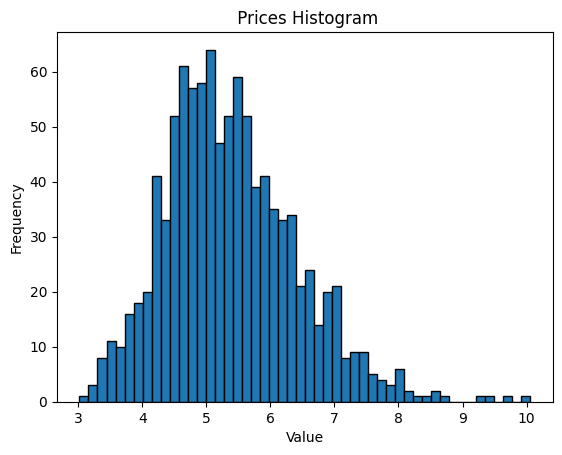

In [6]:
# Create a histogram
plt.hist(df["prices"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(' Prices Histogram')

# Display the plot
plt.show()

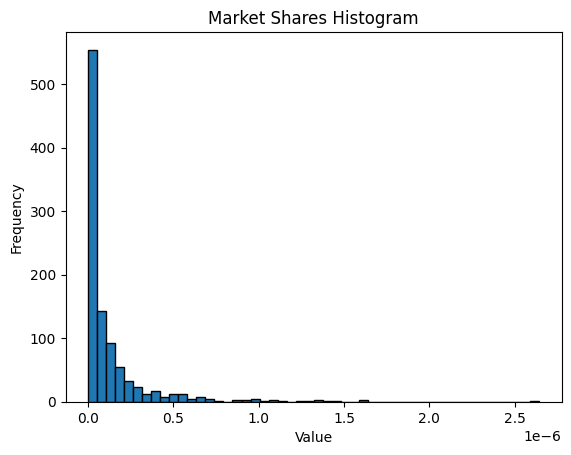

In [7]:
# Create a histogram
plt.hist(df["shares"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Market Shares Histogram')

# Display the plot
plt.show()

### Part 2: Simple Logit Estimation

Exercise 1: Estimate the simple logit model disregarding consumer heterogeneity

Trying to estimate with the logit function: 

$$ ln(s_j) - ln(s_0) =   \beta^{'} x_j + \alpha p_{jt}  $$

Check if this estimation leads to the correct coefficients and what we can do to improve it. 

In [8]:
# Maybe let the students do this in pandas because it seems to much to ask to 
# use the attributes in 1-2 weeks? 
reshape = np.reshape(market_object.market_shares, (T, n_firms))
sum_market_shares = np.sum(reshape, axis=1)
repeated_sum_shares = np.reshape(np.repeat(sum_market_shares, n_firms), (n_firms*T, 1))
y  = np.log(market_object.market_shares) - np.log(repeated_sum_shares)    

In [20]:
x = df[['prices','char1', 'char2']]
# with sklearn
mod = sm.OLS(y, x).fit()
print(mod.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              3403.
Date:                Tue, 24 Oct 2023   Prob (F-statistic):                        0.00
Time:                        12:38:17   Log-Likelihood:                         -1504.5
No. Observations:                1000   AIC:                                      3015.
Df Residuals:                     997   BIC:                                      3030.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Exercise 2: Compare the estimates with the true estimates? What is wrong here? 


In [21]:
print(f"The true parameters are alpha = {market_object.alpha_mean} and beta = \n {market_object.beta_0}  \n\n")


print(f"The estimates parameters are alpha = {mod.params[0]} and beta = \n {mod.params[1:n_char+1]} \n\n")

The true parameters are alpha = -1.7 and beta = 
 [[-1.9833455 ]
 [-3.38661129]]  


The estimates parameters are alpha = -0.750361885036317 and beta = 
 char1    2.566763
char2   -2.372297
dtype: float64 




/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_92322/1101434554.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The estimates parameters are alpha = {mod.params[0]} and beta = \n {mod.params[1:n_char+1]} \n\n")


/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_92322/1053170615.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = mod.params[i+1]
/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_92322/1053170615.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = mod.bse[i+1]


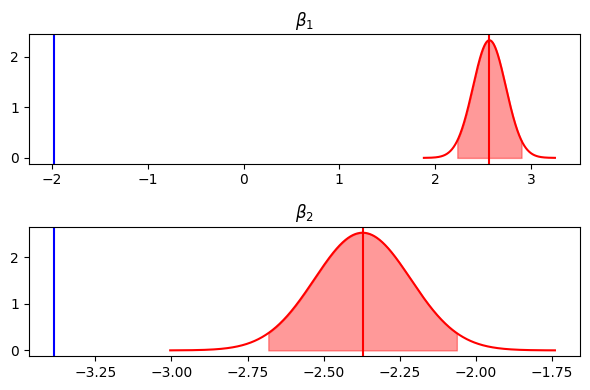

In [11]:
# Additional visualization students do not need to do this but it is good for 
# visualization

fig, axes = plt.subplots(2, 1, figsize=(6, 4))

for i,ax in enumerate(axes.flatten()):
    ax.axvline(market_object.beta_0[i], label="true", color="blue")

    # Plot (distribution of) estimated coefficient
    mu = mod.params[i+1]
    sigma = mod.bse[i+1]
    x1 = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    x2 = np.linspace(mu - 1.96*sigma, mu + 1.96*sigma, 1000)
    
    ax.axvline(mu, label="estimated", color="red")
    ax.plot(x1, stats.norm.pdf(x1, mu, sigma), color="red")
    ax.fill_between(x2, stats.norm.pdf(x2, mu, sigma), color="red", alpha=0.4)
    
    ax.set_title(f"$\\beta_{i+1}$")

plt.tight_layout()
plt.show()

### Part 3: Estimation with the PyBLP package (without supply side problem)


In [12]:
X1_formulation = pyblp.Formulation('0 + prices + char1 + char2')
X2_formulation = pyblp.Formulation('0 + prices + char1 + char2')
product_formulations = (X1_formulation, X2_formulation)
product_formulations

(prices + char1 + char2, prices + char1 + char2)

In [13]:
mc_integration = pyblp.Integration('monte_carlo', size=100, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

In [14]:
mc_problem = pyblp.Problem(product_formulations, df, integration=mc_integration)


Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    MD 
---  ----  ---  -----  ----  ----  ----
100  1000  10   10000   3     3     2  

Formulations:
       Column Indices:           0       1      2  
-----------------------------  ------  -----  -----
 X1: Linear Characteristics    prices  char1  char2
X2: Nonlinear Characteristics  prices  char1  char2


In [15]:
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})


In [16]:
results1 = mc_problem.solve(sigma=np.ones((3, 3)), optimization=bfgs)



The model may be under-identified. The total number of unfixed parameters is 9, which is more than the total number of moments, 2. Consider checking whether instruments were properly specified when initializing the problem, and whether parameters were properly configured when solving the problem.


Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:     prices          char1          char2      |  Sigma Squared:     prices          char1          char2    
------  -------------  -------------  -------------  |  --------------  -------------  -------------  -------------
prices  +1.000000E+00                                |      prices      +1.000000E+00  +1.000000E+00  +1.000000E+00
char1   +1.000000E+00  +1.000000E+00                 |      char1       +1.000000E+00  +2.000000E+00  +2.000000E+00
char2   +1.000000E+00  +1.000000E+00  +1.000000E+00  |      char2       +1.000000E+00  +2.000000E+00  +3.000000E+00
Starting optimization ...


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:


### Part 4 - Here either writing linear estimation themselves or put in the supply side cost structure and disable optimal instruments

In [22]:
product_data = df
# Setting up the formulations
product_formulations = (pyblp.Formulation('0 + prices + char1 + char2'), pyblp.Formulation('0 + prices + char1+ char2'),pyblp.Formulation('cost'))

mc_integration = pyblp.Integration('monte_carlo', size=100, specification_options={'seed': 0})
problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-6})
estimation = problem.solve(sigma=(np.ones((3, 3))/2),beta=[1., 1., 1.], optimization=bfgs)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
100  1000  10   10000   3     3     2     2     2  

Formulations:
        Column Indices:            0       1      2  
-------------------------------  ------  -----  -----
  X1: Linear Characteristics     prices  char1  char2
 X2: Nonlinear Characteristics   prices  char1  char2
X3: Linear Cost Characteristics    1     cost        
Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:     prices          char1          char2      |  Sigma Squared:     prices          char1          char2    
------  -------------  -------------  -------------  |  --------------  -------------  -------------  -------------
prices  +5.000000E-01                                |      prices      +2.500000E-01  +2.500000E-01  +2.500000E-01
char1   +5.000000E-01  +5.000000E-01                 |      char1 

The model may be under-identified. The total number of unfixed parameters is 11, which is more than the total number of moments, 4. Consider checking whether instruments were properly specified when initializing the problem, and whether parameters were properly configured when solving the problem.


 1     00:00:00         0             2           101          425         0     +6.061406E+05  +4.980189E+05  +2.635576E+05  -3.331992E-01, +2.405123E-01, +3.882710E-01, +2.627543E-01, +3.973113E-01, +4.555031E-01, +6.125518E-01, +8.784734E-01, +8.887946E-01
 1     00:00:00         1             3           101          409         0     +6.817611E+04  +5.379644E+05  +8.800568E+04  -7.137597E-02, +2.898235E-01, -4.367181E-01, +3.036450E-01, -3.622721E-01, +4.748677E-02, -1.896618E+00, +9.146177E-02, +1.683967E-01

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point itera

### Alternative (part of the assignment): Guided Monte-Carlo Generation
